In [1]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from tensorflow import keras
import random
import tensorflow as tf
import seaborn
from matplotlib import pyplot
import numpy
import pandas


2021-11-21 05:51:14.645409: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-21 05:51:14.645561: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## How to read a CT Scan

https://www.youtube.com/watch?v=9TdBLnSjACA
<h2 align="center" style="background:blue; padding:4px; color:white">Common findings in Covid and Pneumonia</h2>

|||
|:----:|:----:|
|<img src=https://litfl.com/wp-content/uploads/2020/04/Shows-isolated-ground-glass-opacity-in-right-lower-lobe.jpg width="300px" height="300px">|<img src="https://www.wikidoc.org/images/e/e1/Lobar-pneumonia-ct-findings.jpg" width="300px" height="300px">|
|__ground-glass opaities (GGO)__|__Consolidation__|
|<img src="https://radiologykey.com/wp-content/uploads/2016/09/00029.jpeg" width="300px" height="300px">|<img src="https://upload.wikimedia.org/wikipedia/commons/f/fc/Bullus_emphasemaCT.png" width="300px" height="300px">|
|__Reticulation__|__Emphysema__|
|<img src="https://prod-images-static.radiopaedia.org/images/171516/c2c5ebb3b7c4dc6065ebc2cc3ddba1_gallery.jpg"  width="300px" height="300px">|<img src="http://www.stritch.luc.edu/lumen/MedEd/Radio/curriculum/Medicine/image116a.jpg" width="300px" height="300px">|
|__thickening of the adjacent pleura__|__pleural effusion__|
|<img src="https://pubs.rsna.org/cms/10.1148/radiol.2017162894/asset/images/medium/radiol.2017162894.fig14.gif"  width="300px" height="300px">|<img src="https://www.msdmanuals.com//-/media/manual/professional/images/b/r/o/bronchiectasis.jpg?thn=0&sc_lang=en"  width="300px" height="300px">|
|__presence of nodules or masses__|__bronchiectasis__|

<h2 align="center" style="background:blue; padding:4px;color:white;">Number of images per class label</h2>

In [2]:
import os
sdir = r'../input/large-covid19-ct-slice-dataset/curated_data/curated_data'
filepaths = []
labels = []
classlist = os.listdir(sdir)
for item in classlist:
    classpath = os.path.join(sdir, item)
    flist = os.listdir(classpath)
    for f in flist:
        fpath = os.path.join(classpath, f)
        filepaths.append(fpath)
        labels.append(item)

df = pandas.DataFrame()
df['filepath'] = filepaths
df['labels'] = labels
print(df['labels'].value_counts())
df = df.sample(frac=1).reset_index(drop=True)

2COVID       7593
1NonCOVID    6893
3CAP         2618
Name: labels, dtype: int64


<h3 align="left" style="color:blue; padding:4px;">Conclusion</h3>

Dataset is highly imbalanced.

<h2 align="center" style="background:blue; padding:4px; color:white">Sample Images</h2>

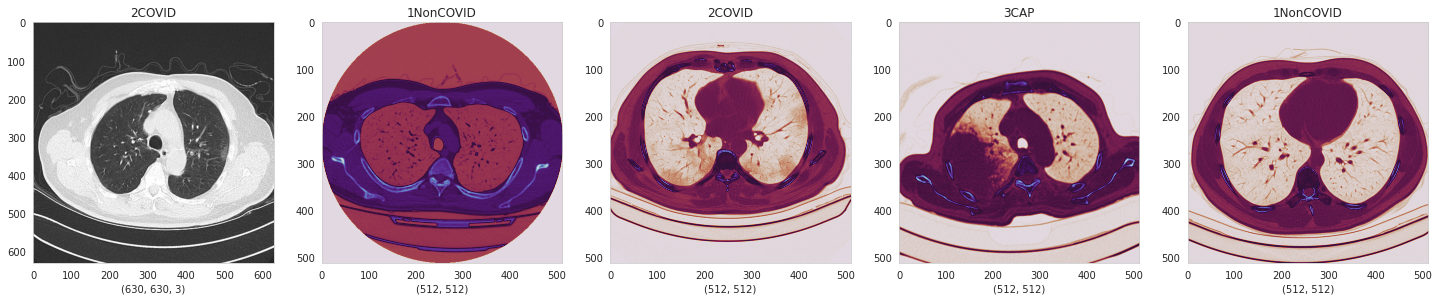

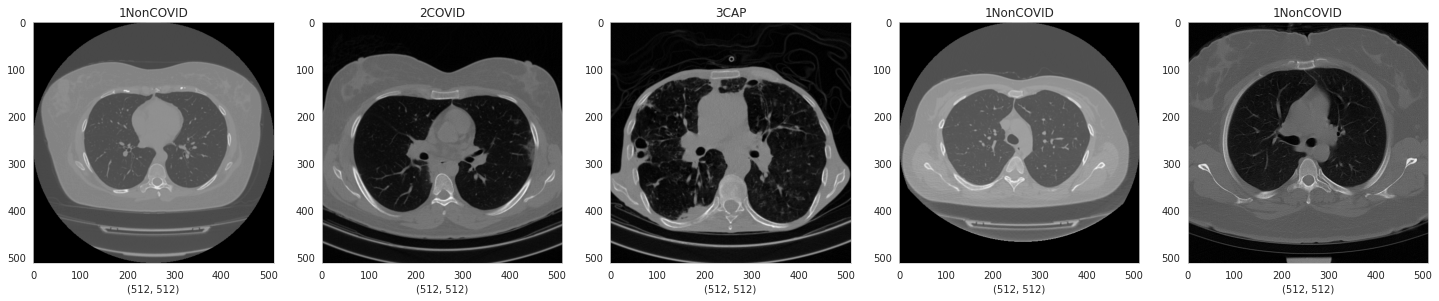

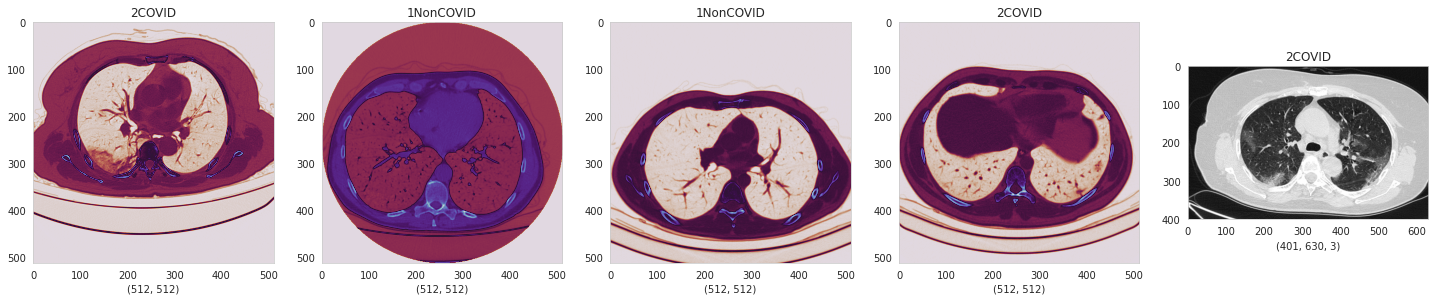

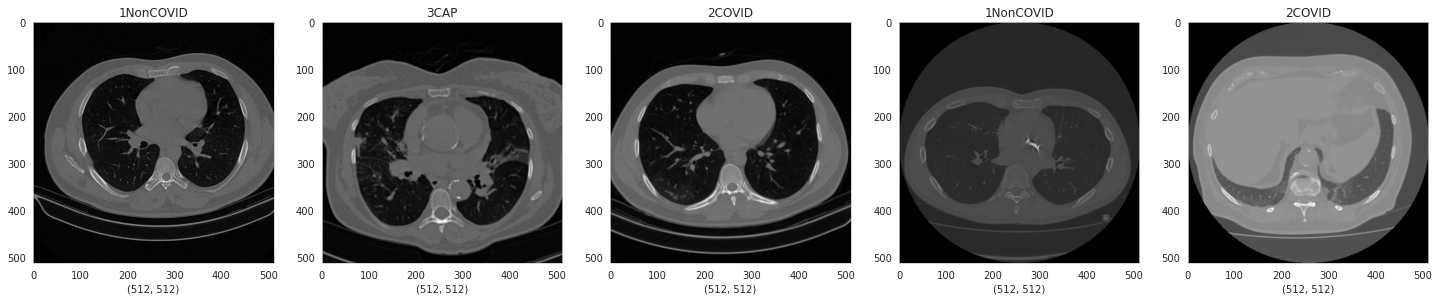

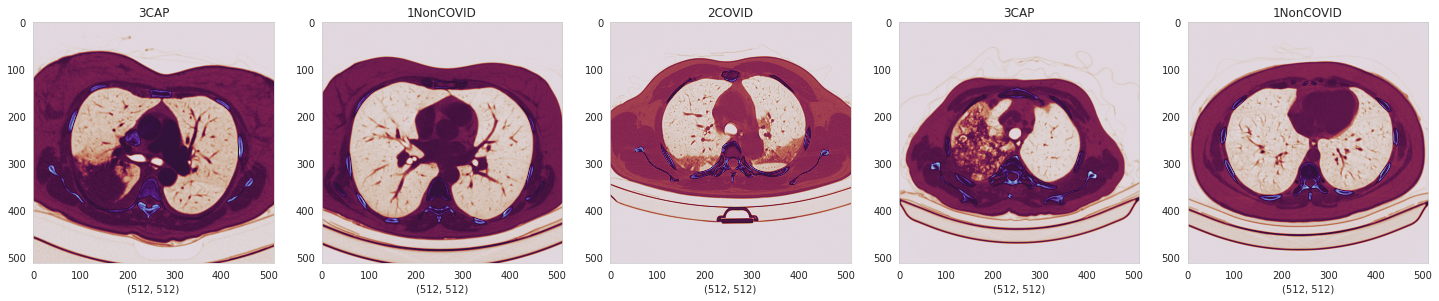

In [3]:
seaborn.set_style("whitegrid", {'axes.grid': False})

for i in range(5):
    fig = pyplot.figure(figsize=(25, 23))
    for j in range(5):
        index = i*5+j+1
        pyplot.subplot(1, 5, j+1)
        pyplot.title(df.loc[index, 'labels'])
        img = pyplot.imread(df.loc[index, 'filepath'])
        pyplot.xlabel(f'{img.shape}')
        pyplot.imshow(img, cmap="twilight_r" if i % 2 == 0 else "gray")
        j += 1
    i += 1
    pyplot.show()

<h3 align="left" style="color:blue; padding:4px;">Conclusion</h3>

- There are images with 2, 3 and 4 channels.
- By observing gray images, There are some images which have light contrast background, while some have dark. So, preprocessing all images to their negetives will not help in such case. It's good because in real world scenario, we will also get a mixed type of data

In [4]:
%%html
<iframe src="https://wandb.ai/ashuto7h/covid19/reports/Shared-panel-21-11-21-11-11-11--VmlldzoxMjQ4Nzg2?highlightShare" style="border:none;height:800px;width:100%"></iframe>

In [5]:
%%html
<iframe src="https://wandb.ai/ashuto7h/covid19/reports/Shared-panel-21-11-21-11-11-96--VmlldzoxMjQ4Nzg0?highlightShare" style="border:none;height:800px;width:100%"></iframe>

In [6]:
class_weights = {2: 2.17774382, 0: 0.8271193, 1: 0.75086703}
class_map = {'2COVID': 1, '1NonCOVID': 0, '3CAP': 2}

In [7]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=32, shuffle=True, color_mode="rgb"):
        self.batch_size = batch_size
        self.df = df
        self.indices = self.df.index.tolist()
        self.shuffle = shuffle
        self.on_epoch_end()
        self.color_mode = color_mode

    def __len__(self):
        return len(self.indices) // self.batch_size

    def __getitem__(self, index):
        index = self.index[index *
                           self.batch_size:(index + 1) *
                           self.batch_size]
#         print(index)
        batch = [self.indices[k] for k in index]
        X, y = self.__get_data(batch)
        return X, y

    def on_epoch_end(self):
        self.index = numpy.arange(len(self.indices))
        if self.shuffle == True:
            numpy.random.shuffle(self.index)

    def __get_data(self, batch):
        X = []
        y = []
        for i, id in enumerate(batch):
            img = tf.keras.preprocessing.image.load_img(
                self.df.loc[id, 'filepath'],
                color_mode=self.color_mode,
                target_size=(256, 256),
                interpolation="nearest")
            img_array = tf.keras.preprocessing.image.img_to_array(img)
            X.append(img_array/255)
            ylist = [0, 0, 0]
            ylist[class_map[self.df.loc[id, 'labels']]] = 1
            ylist = numpy.array(ylist)
            y.append(ylist)
        X = numpy.array(X)
        y = numpy.array(y)
        return X, y

In [8]:
def test_walk(model, test_df, walks=5, color_mode='rgb'):
    fig = pyplot.figure(figsize=(25, 20))
    for i in range(walks):
        r = random.randint(0, len(test_df))
        img = tf.keras.preprocessing.image.load_img(
            test_df.loc[r, 'filepath'],
            color_mode=color_mode,
            target_size=(256, 256),
            interpolation="nearest")
        img_array = tf.keras.preprocessing.image.img_to_array(img)
        pyplot.subplot(1, 5, i+1)
        try:
            pyplot.imshow(pyplot.imread(test_df.loc[r, 'filepath']),cmap='twilight_r')
        except:
            walks += 1
        pyplot.title(test_df.loc[r, 'labels'])
        tester = numpy.array([img_array])/255
        x = model.predict(tester)
        ncovid = x[0][0]*100
        covid = x[0][1]*100
        cap = x[0][2]*100
        pyplot.xlabel(
            f'{ncovid:.2f}% nCOVID | {covid:.2f}% COVID | {cap:.2f}% CAP')

In [9]:
test_r = DataGenerator(df[100:1000].copy().reset_index(drop=True),shuffle=False)
labels = []
for image, label in test_r:
    labels.append(label)
labels = numpy.array(labels).reshape(-1, 3)
labels = numpy.argmax(labels, axis=-1)
# print(labels)

def cnf_matrix(model, test_r):
    predictions = model.predict(test_r, verbose=1)
    y_pred = numpy.argmax(predictions, axis=-1)
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    # get the classification report
    cr = classification_report(labels, y_pred)
    print(cr)
    cm = confusion_matrix(labels, y_pred)
    x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
    display(x)

### RESNET50

2021-11-21 05:51:44.685870: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-21 05:51:44.690039: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-21 05:51:44.690087: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-21 05:51:44.690122: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f14fc8ef7c5d): /proc/driver/nvidia/version does not exist
2021-11-21 05:51:44.690697: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

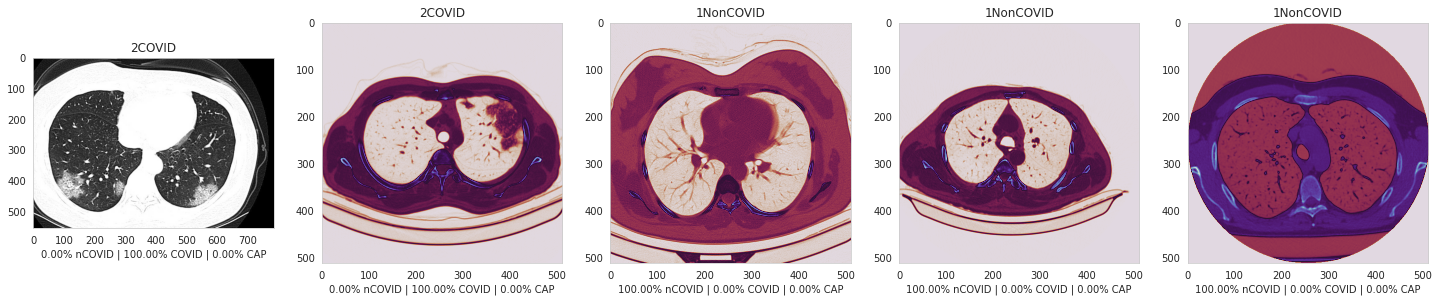

In [10]:
resnet50_model = keras.models.load_model(
    '../input/k/ashuto7h/k/ashuto7h/k/ashuto7h/covid19-detection-5-resnet-50-transfer-learn/Resnet_v13.h5')
test_walk(resnet50_model, df)

28/28 [==============================] - 119s 4s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       348
           1       0.98      0.98      0.98       397
           2       1.00      0.99      0.99       151

    accuracy                           0.98       896
   macro avg       0.99      0.98      0.99       896
weighted avg       0.98      0.98      0.98       896



<AxesSubplot:>

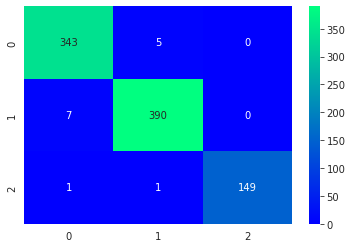

In [11]:
cnf_matrix(resnet50_model, test_r)

### XCEPTION

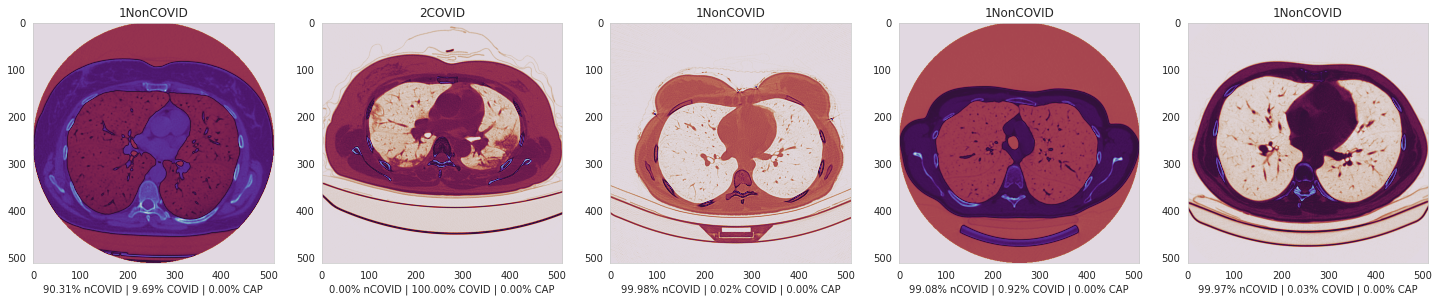

In [12]:
xception_model = keras.models.load_model(
    '../input/k/ashuto7h/k/ashuto7h/k/ashuto7h/covid19-detection-2-xception-transfer-learn/Xception_v10.h5')
test_walk(xception_model, df)

28/28 [==============================] - 152s 5s/step
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       348
           1       0.99      0.99      0.99       397
           2       1.00      0.99      1.00       151

    accuracy                           0.99       896
   macro avg       0.99      0.99      0.99       896
weighted avg       0.99      0.99      0.99       896



<AxesSubplot:>

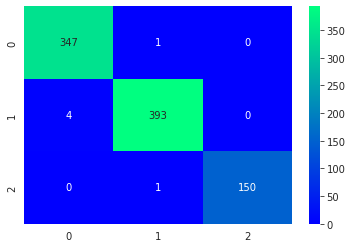

In [13]:
cnf_matrix(xception_model, test_r)

### MOBILENET

17227776/17225924 [==============================] - 0s 0us/step


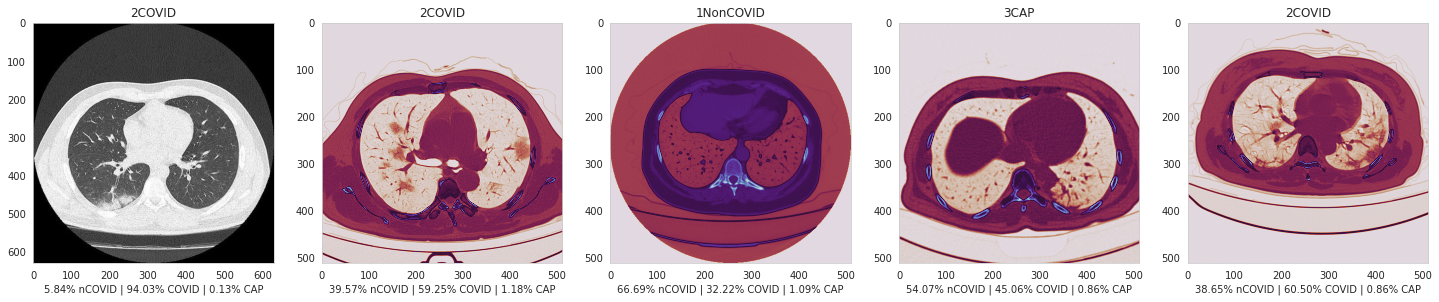

In [14]:
def build_model():
    inputs = layers.Input(shape=(256, 256, 3))
    x = tf.keras.applications.mobilenet.preprocess_input(inputs)
    x = MobileNet(include_top=False, weights='imagenet',
                  input_shape=(256, 256, 3))(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = BatchNormalization()(x)
    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

mobilenet = build_model()
mobilenet.load_weights('../input/k/ashuto7h/k/ashuto7h/k/ashuto7h/covid19-detection-mobilenet/MobileNet_v3.h5')
test_walk(mobilenet, df)

28/28 [==============================] - 36s 1s/step
              precision    recall  f1-score   support

           0       0.50      0.80      0.62       348
           1       0.67      0.57      0.62       397
           2       0.00      0.00      0.00       151

    accuracy                           0.56       896
   macro avg       0.39      0.46      0.41       896
weighted avg       0.49      0.56      0.51       896



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<AxesSubplot:>

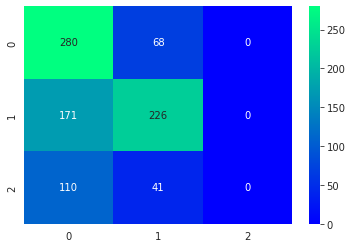

In [15]:
cnf_matrix(mobilenet, test_r)

### CUSTOM CNN

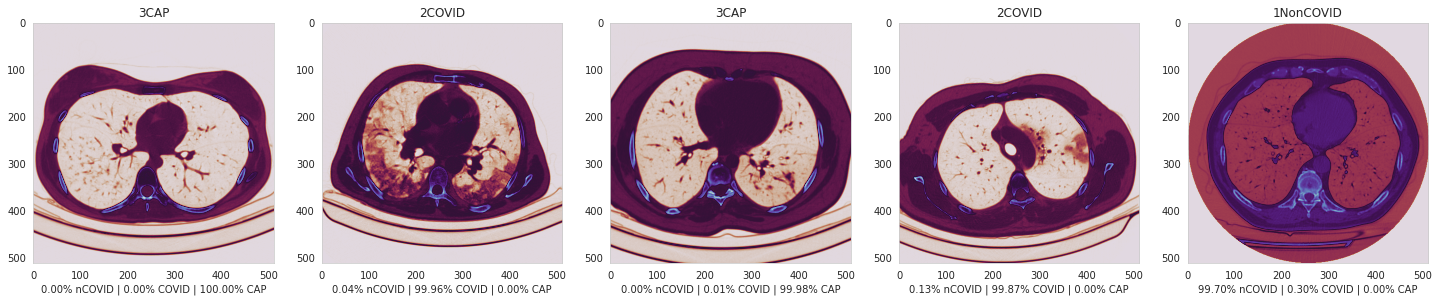

In [16]:
custom_model = keras.models.load_model(
    '../input/cnn-covid-0/custom_cnn.h5')
test_walk(custom_model, df)

28/28 [==============================] - 39s 1s/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       348
           1       0.97      0.99      0.98       397
           2       1.00      0.99      0.99       151

    accuracy                           0.98       896
   macro avg       0.99      0.98      0.99       896
weighted avg       0.98      0.98      0.98       896



<AxesSubplot:>

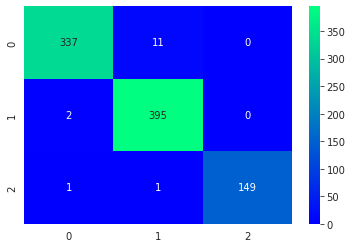

In [17]:
cnf_matrix(custom_model, test_r)

In [18]:
# def preds(pred):
#     return f'{round(pred[0],3)} {round(pred[1],3)} {round(pred[2],3)}'

# def cnf_matrix2(model, test_r):
#     predictions = model.predict(test_r, verbose=1)
#     y_pred = numpy.argmax(predictions, axis=-1)
#     global labels
#     from sklearn.metrics import confusion_matrix
#     from sklearn.metrics import classification_report
#     # get the classification report
#     for i in range(len(predictions)):
#         if y_pred[i]!=labels[i]:
#             print(f'{labels[i]} {preds(predictions[i])}')
# #     cr = classification_report(labels, y_pred)
# #     print(cr)
# #     cm = confusion_matrix(labels, y_pred)
# #     x = seaborn.heatmap(cm, cmap='winter', annot=True, fmt='d')
# #     display(x)

In [19]:
# sec_df = df[:100].copy().reset_index(drop=True)
# def test_walk2(model, test_df, color_mode='rgb'):
#     i = 99
#     j = 0
#     global sec_df
# #     for label in test_df['labels'].unique():
#     while True:
#         img = tf.keras.preprocessing.image.load_img(
#             test_df.loc[j, 'filepath'],
#             color_mode=color_mode,
#             target_size=(256, 256),
#             interpolation="nearest")
#         j += 1
#         img_array = tf.keras.preprocessing.image.img_to_array(img)
#         tester = numpy.array([img_array])/255
#         x = model.predict(tester)
#         ncovid = x[0][0]*100
#         covid = x[0][1]*100
#         cap = x[0][2]*100
#         label = test_df.loc[j,'labels']
# #             print(f'{label} {ncovid} {covid} {cap}')
#         if(label =='2COVID' and covid>ncovid and covid >cap):
# #                 tf.keras.preprocessing.image.save_img(f'{label}_{i}.png',img_array)
#             i += 1
#             sec_df = sec_df.append({'filepath':test_df.loc[j,'filepath'],'labels':'2COVID'},ignore_index=True)
#             print(f'found {label} {covid}')

#         elif(label =='1NonCOVID' and ncovid>covid and ncovid >cap):
# #                 tf.keras.preprocessing.image.save_img(f'{label}_{i}.png',img_array)
#             i += 1
#             sec_df = sec_df.append({'filepath':test_df.loc[j,'filepath'],'labels':'1NonCOVID'},ignore_index=True)
#             print(f'found {label} {ncovid}')

#         elif(label =='3CAP' and cap>ncovid and cap >covid):
# #                 tf.keras.preprocessing.image.save_img(f'{label}_{i}.png',img_array)
#             i += 1
#             sec_df = sec_df.append({'filepath':test_df.loc[j,'filepath'],'labels':'3CAP'},ignore_index=True)
#             print(f'found {label} {cap}')
#         if i > 1000:
#             break
#     i = 0